In [49]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import torch

matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams.update({'font.size': 16})


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 2000

feature_dims = ["Color", "Shape", "Pattern"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [42]:
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_50_bins.pickle"))
firing_rates = firing_rates[firing_rates.TrialNumber >= 57]

### Look at Unit 52, Split by FB

In [43]:
unit_fr = firing_rates[firing_rates.UnitID == 52]
cor_trials = valid_beh[valid_beh.Response == 'Correct'].TrialNumber
inc_trials = valid_beh[valid_beh.Response == 'Incorrect'].TrialNumber

cor_fr = unit_fr[unit_fr.TrialNumber.isin(cor_trials)]
inc_fr = unit_fr[unit_fr.TrialNumber.isin(inc_trials)]

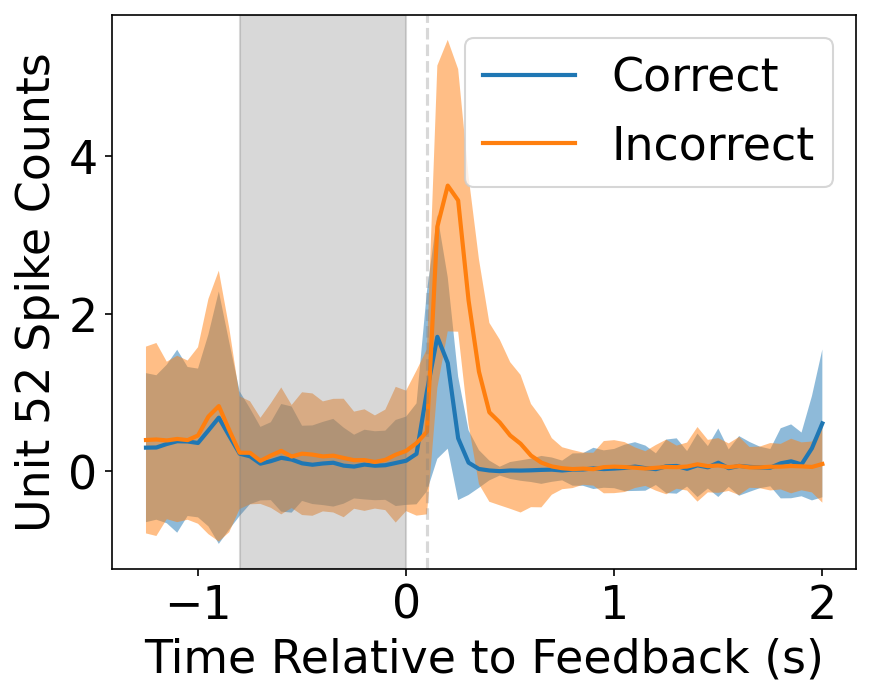

In [50]:
trans_cor = np.stack(cor_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())
trans_inc = np.stack(inc_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    trans_cor,
    1.3, 2, .05,
    ax,
    label="Correct",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    trans_inc,
    1.3, 2, .05,
    ax,
    label="Incorrect",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Unit 52 Spike Counts")
ax.legend()
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")

### Look at Unit 14, Split by Color

In [45]:
selections = behavioral_utils.get_selection_features(valid_beh)

In [46]:
yellow_trials = selections[selections.Color == "YELLOW"].TrialNumber
other_trials = selections[~selections.TrialNumber.isin(yellow_trials)].TrialNumber


unit_fr = firing_rates[firing_rates.UnitID == 14]
yellow_fr = unit_fr[unit_fr.TrialNumber.isin(yellow_trials)]
other_fr = unit_fr[unit_fr.TrialNumber.isin(other_trials)]

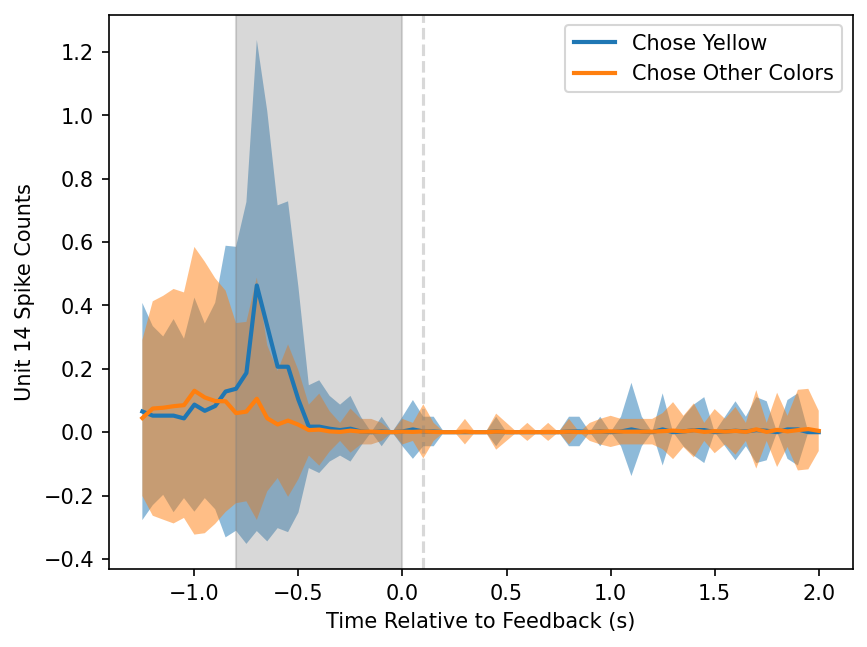

In [48]:
trans_yellow = np.stack(yellow_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())
trans_other = np.stack(other_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    trans_yellow,
    1.3, 2, .05,
    ax,
    label="Chose Yellow",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    trans_other,
    1.3, 2, .05,
    ax,
    label="Chose Other Colors",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Unit 14 Spike Counts")
ax.legend()
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")